Estimating the size of the TESS/whatever dataset

In [1]:
# All guesses.
years = 8 
sample_interval_min = 5
pixels_per_sample = 10 * 10 
bytes_per_pixel = 4
stars = 2000

# Estimating the size.
minutes = years * 365 * 24 * 60
samples_per_star = minutes / sample_interval_min
total_size = samples_per_star * pixels_per_sample * bytes_per_pixel * stars

print(f'{total_size:,} bytes')

672,768,000,000.0 bytes


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
DATA = Path.cwd().parent / "data" / "CONFIRMED"

In [4]:
K2_3 = DATA / "K2-3.csv"

In [5]:
df = pd.read_csv(K2_3)

In [6]:
df.head()

,time,flux,flux_err
0,1977.242017,0.965237,0.000045
1,1977.262449,1.025735,0.000046
2,1977.282882,1.025550,0.000046
3,1977.303314,1.025327,0.000046
4,1977.323746,0.999550,0.000045


In [7]:
df.shape

(3738, 3)

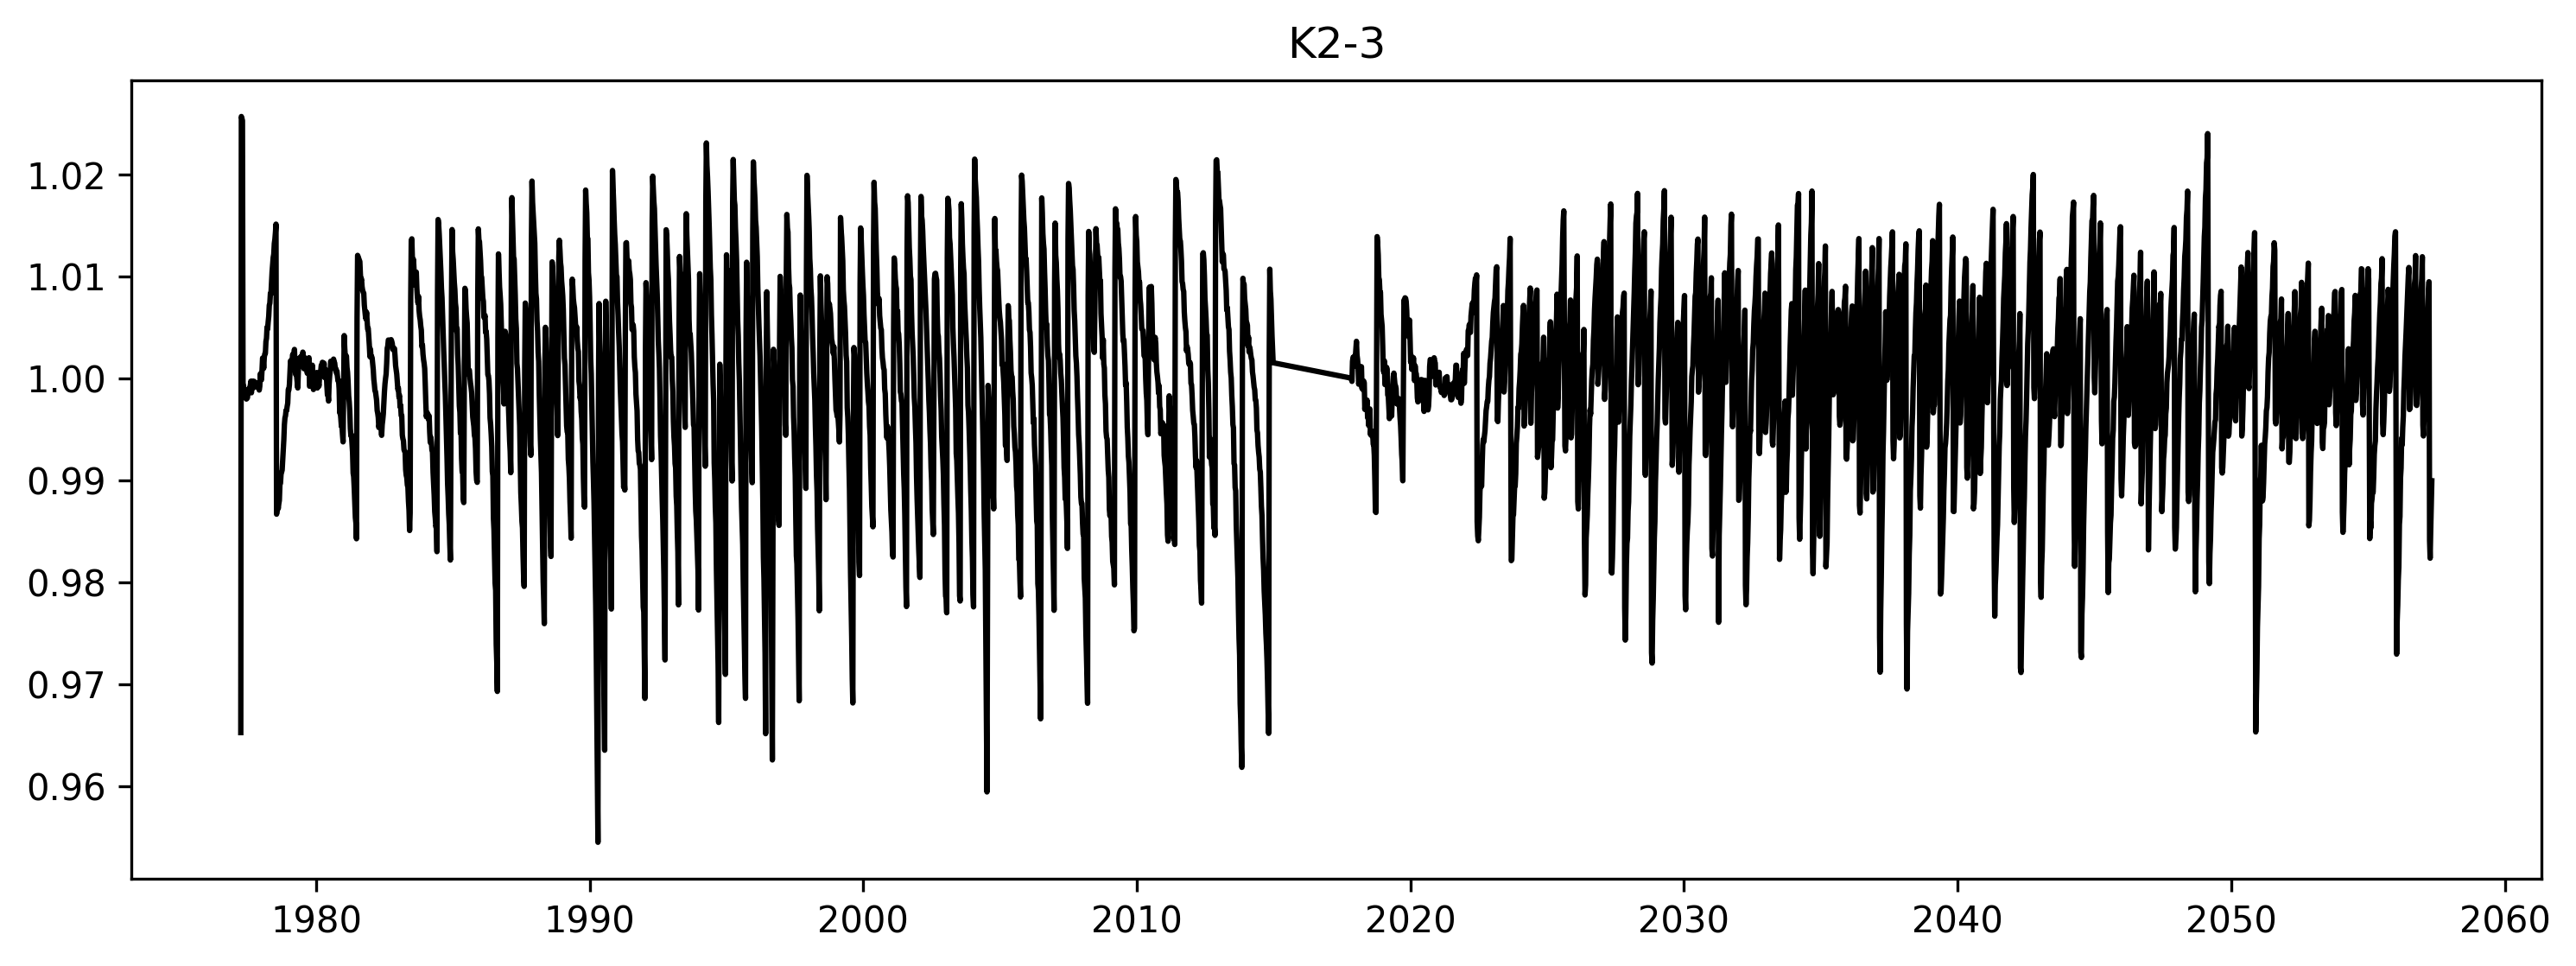

In [9]:
plt.figure(figsize=(12, 4), dpi=300)
plt.title("K2-3")
plt.plot(df["time"], df["flux"], "k-")
plt.show()

# Copying some code from astropy to learn

## Estimating periods

In [12]:
import numpy.typing as npt

In [33]:
def autoperiod(
    t: npt.NDArray,
    y: npt.NDArray,
    dy: npt.NDArray,
    duration: float | list[float],
    minimum_period: float | None = None,
    maximum_period: float | None = None,
    minimum_n_transit: int = 3,
    frequency_factor: float = 1.0,
):
    # Check that the input arrays have the same length.
    all_equal_length = len(t) == len(y) == len(dy)
    assert all_equal_length, "t, y, and dy must have the same length"

    # Check that the duration is a scalar.
    assert isinstance(duration, (float, list)), \
        "duration must be a scalar or a list"

    if isinstance(duration, float):
        duration = [duration]

    # Check that all durations are float.
    assert all(isinstance(d, float) for d in duration), \
        "all durations must be float"

    # Check that the duration is positive.
    assert all(d > 0 for d in duration), "duration must be positive"

    # Check that the minimum period is positive.
    if minimum_period is not None:
        assert minimum_period > 0, "minimum_period must be positive"
    else:
        minimum_period = 2.0 * np.max(duration)

    # Compute the baseline.
    baseline = np.ptp(t)
    min_duration = np.min(duration)

    # Check that the maximum period is positive.
    if maximum_period is not None:
        assert maximum_period > 0, "maximum_period must be positive"
    else:
        maximum_period = baseline

    # Check that the minimum period is less than the maximum period.
    assert minimum_period < maximum_period, \
        "minimum_period must be less than maximum_period"

    # Check that the minimum number of transits is positive.
    assert minimum_n_transit > 0, "minimum_n_transit must be positive"

    # Check that the frequency factor is positive.
    assert frequency_factor > 0, "frequency_factor must be positive"

    # Estimate the required frequency spacing
    # Because of the sparsity of a transit, this must be much finer than
    # the frequency resolution for a sinusoidal fit. For a sinusoidal fit,
    # df would be 1/baseline (see LombScargle), but here this should be
    # scaled proportionally to the duration in units of baseline.
    df = frequency_factor * min_duration / baseline**2

    # Convert bounds to frequency
    minimum_frequency = 1.0 / maximum_period
    maximum_frequency = 1.0 / minimum_period

    # Compute the number of frequencies and the frequency grid
    nf = 1 + int(np.round((maximum_frequency - minimum_frequency) / df))
    return 1.0 / (maximum_frequency - df * np.arange(nf))


In [40]:
durations = list(np.linspace(0.1, 2, 100))
t = df["time"]
y = df["flux"]
dy = df["flux_err"]

In [41]:
periods = autoperiod(t, y, dy, duration=durations)
print(len(periods))

15237


In [ ]:
def new_bls(t, y, dy, durations):
    def model(t, y, w, p, d, phi):
        # Calcula o D do paper do Kovacs
        is_transit = float(0 <= ((t % p) - phi) <= d)
        r = np.sum(w * is_transit)
        s = np.sum(w * y * is_transit)
        wx = np.sum(w * y * y)

        return wx - (s**2)/(r * (1 - r))

    w = 1.0 / dy**2
    w = w / np.sum(w)

    for d in durations:
        periods = autoperiod(t, y, dy, duration=d)
        for p in periods:
            phi = autophi(t, y, dy, p, d)
            result = model(t, y, w, p, d, phi)
            # to be continued


In [ ]:
def old_bls(time, flux, flux_err, periods, durations):
    best_period = None
    best_phase = None
    best_D = np.inf
    best_indices = None

    for period in periods:
        for duration in durations:
            for phase in np.linspace(0, period, int(period / duration)):
                r = duration / period
                weights = 1 / flux_err**2
                x = flux - np.mean(flux)
                
                in_transit = (time % period >= phase) & (time % period < phase + duration)
                s = np.sum(weights[in_transit] * x[in_transit])
                
                D = np.sum(weights[in_transit] * x[in_transit]**2) - (s**2 / (r * (1 - r)))
                
                if D < best_D:
                    best_D = D
                    best_period = period
                    best_phase = phase
                    best_indices = np.where(in_transit)
    
    return best_period, best_phase, best_indices

In [ ]:
def bls(time, flux, flux_err, periods, durations, num_bins=200):
    best_period = None
    best_phase = None
    best_D = np.inf
    best_indices = None

    for period in periods:
        for duration in durations:
            for phase in np.linspace(0, period, int(period / duration)):
                r = duration / period
                weights = 1 / flux_err**2
                x = flux - np.mean(flux)
                
                # Bin the folded time series
                folded_time = (time % period) - phase
                folded_time[folded_time < 0] += period  # Ensure all times are positive
                binned_time = np.linspace(0, period, num_bins)
                bin_indices = np.digitize(folded_time, binned_time) - 1
                
                bin_sums = np.zeros(num_bins)
                bin_weights = np.zeros(num_bins)
                bin_fluxes = np.zeros(num_bins)
                
                for i in range(num_bins):
                    bin_mask = (bin_indices == i)
                    bin_sums[i] = np.sum(weights[bin_mask] * x[bin_mask])
                    bin_weights[i] = np.sum(weights[bin_mask])
                    bin_fluxes[i] = np.sum(weights[bin_mask] * x[bin_mask]**2)
                
                # Calculate the BLS statistic
                in_transit_bins = (binned_time >= 0) & (binned_time < duration)
                s = np.sum(bin_sums[in_transit_bins])
                D = np.sum(bin_fluxes[in_transit_bins]) - (s**2 / (r * (1 - r)))
                
                if D < best_D:
                    best_D = D
                    best_period = period
                    best_phase = phase
                    best_indices = np.where(in_transit_bins[bin_indices])
    
    return best_period, best_phase, best_indices

In [ ]:
periods = np.linspace(15,25,100)
duration = np.linspace(0.01, 0.2, 100)

In [ ]:
best_period, best_phase, best_indices = bls(df.time, df.flux, df.flux_err, periods, duration)

In [ ]:
print(f"Best period: {best_period}")
print(f"Best phase: {best_phase}")
print(f"Indices: {best_indices}")